In [ ]:
!pip install imbalanced-learn
!pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from pprint import pprint

#IMPORTANDO O DATASET

In [ ]:
df = pd.read_csv("Mentalhealth.csv", low_memory=False)

df.head()

,COUNTRYNEW,WPID_RANDOM,WGT,PROJWT,FIELD_DATE,YEAR_WAVE,W1,W2,W3,W4,...,age_var1,age_var2,age_var3,Gender,Education,Household_Income,Global11Regions,wbi,Subjective_Income,EMP_2010
0,United States,178216898,0.803440,211560.29700,10/01/2020,2020,2,1,2,2,...,3,4,4,2,2,5,9,4,2,6
1,United States,159107018,0.729590,192114.26740,10/01/2020,2020,1,1,3,1,...,1,1,1,1,3,4,9,4,1,1
2,United States,203166417,0.848559,223440.98710,10/01/2020,2020,1,1,3,1,...,1,1,2,1,3,4,9,4,1,1
3,United States,201061719,0.341083,89813.41772,10/01/2020,2020,2,1,3,2,...,3,3,4,2,3,4,9,4,2,1
4,United States,195404162,0.995933,262247.16630,10/01/2020,2020,3,1,2,1,...,2,2,3,1,2,2,9,4,4,6


#ANALISE EXPLORATORIA DE DADOS E PRÉ-PROCESSAMENTO

##Filtrando o dataset para somente paises sul americanos

In [ ]:

# Verificar o nome exato da coluna de países
df['COUNTRYNEW'].unique()


array(['United States', 'Egypt', 'Morocco', 'Lebanon', 'Saudi Arabia',
       'Jordan', 'Turkey', 'Indonesia', 'Bangladesh', 'United Kingdom',
       'France', 'Germany', 'Netherlands', 'Belgium', 'Spain', 'Italy',
       'Poland', 'Hungary', 'Czech Republic', 'Romania', 'Sweden',
       'Greece', 'Denmark', 'Iran', 'Hong Kong', 'Japan', 'China',
       'India', 'Venezuela', 'Brazil', 'Mexico', 'Nigeria', 'Kenya',
       'Tanzania', 'Israel', 'Ghana', 'Uganda', 'Benin', 'South Africa',
       'Canada', 'Australia', 'Philippines', 'Sri Lanka', 'Vietnam',
       'Thailand', 'Cambodia', 'Laos', 'Myanmar', 'New Zealand',
       'Ethiopia', 'Mali', 'Senegal', 'Zambia', 'South Korea', 'Taiwan',
       'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Moldova', 'Russia',
       'Ukraine', 'Burkina Faso', 'Cameroon', 'Zimbabwe', 'Costa Rica',
       'Albania', 'Algeria', 'Argentina', 'Austria', 'Bahrain', 'Bolivia',
       'Bosnia Herzegovina', 'Bulgaria', 'Chile', 'Colombia',
       'Congo Brazzaville'

In [ ]:
paises_sul_americanos = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia',
    'Ecuador', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela'
]

df_SulAmericanos = df[df['COUNTRYNEW'].isin(paises_sul_americanos)]

#Verificando a quantidade de amostras do novo dataset
df_SulAmericanos['COUNTRYNEW'].unique()



array(['Venezuela', 'Brazil', 'Argentina', 'Bolivia', 'Chile', 'Colombia',
       'Ecuador', 'Paraguay', 'Peru', 'Uruguay'], dtype=object)

##Removendo colunas que sao somente de descrição ou não tem necessidade de estudo para o dataset

In [ ]:

df_SulAmerica_util = df_SulAmericanos.drop(columns=['WPID_RANDOM', 'FIELD_DATE', 'PROJWT', 'WGT',
                      'YEAR_WAVE','Global11Regions','age_var1',
                      'age_var2', 'Age','WP21757', 'WP21758',
                      'WP21759', 'WP21760', 'WP21761', 'WP21768',
                      'W10', 'W13', 'W14', 'W15',
                      'W15_1A', 'W15_1B', 'W15_1C',
                      'W15_1D','W15_1E','W15_2A', 'W15_2B','W30'])
df_SulAmerica_util.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 32689 to 117083
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   COUNTRYNEW         10028 non-null  object
 1   W1                 10028 non-null  int64 
 2   W2                 10028 non-null  int64 
 3   W3                 10028 non-null  object
 4   W4                 10028 non-null  object
 5   W5A                10028 non-null  int64 
 6   W5B                10028 non-null  object
 7   W5C                10028 non-null  int64 
 8   W5D                10028 non-null  object
 9   W5E                10028 non-null  int64 
 10  W5F                10028 non-null  int64 
 11  W5G                10028 non-null  int64 
 12  W6                 10028 non-null  int64 
 13  W7A                10028 non-null  int64 
 14  W7B                10028 non-null  int64 
 15  W7C                10028 non-null  object
 16  W8                 10028 non-null  int64

## Transformando as colunas object em int e aplicando ordinalidade ( se necessario )

In [ ]:
colunas_ordinais = [
    'W1','W2','W3', 'W4', 'W5A','W5B','W5C', 'W5D','W5E','W5F','W5G','W6','W7A','W7B', 'W7C','W8','W9','W11A'
    ,'W14','W11B',
    'W30', 'age_mh', 'Household_Income',
    'MH1', 'MH2A', 'MH2B', 'MH3B', 'MH4B', 'MH5', 'MH6', 'MH3A','MH3B','MH3C','MH3D',
    'MH4A','MH4B','MH5','MH9A','MH9B', 'MH9C', 'MH9D', 'MH9E', 'MH9F',
    'MH9G','MH9H','W28','W29', 'age_mh', 'wbi', 'subjective_Income'
]

colunas_ordinais_inverter = [
    'W1','W2','W3', 'W4', 'W5A','W5B','W5C', 'W5D','W5E','W5F','W5G','W6','W7A','W7B', 'W7C','W8','W9','W11A'
    ,'W14','W11B',
    'W30',
    'MH1', 'MH2A', 'MH2B', 'MH3B', 'MH4B', 'MH5', 'MH6', 'MH3A','MH3B','MH3C','MH3D',
    'MH4A','MH4B','MH5','MH9A','MH9B', 'MH9C', 'MH9D', 'MH9E', 'MH9F',
    'MH9G','MH9H','W28','W29', 'age_mh', 'wbi', 'subjective_Income'
]

colunas_nominais = ['COUNTRYNEW','MH7B_2','EMP_2010']

colunas_booleanas = ['MH6','MH7A','MH7C','MH8A','MH8B','MH8C','MH8D','MH8E','MH8F','MH8G','MH8H','W27']

for col in colunas_ordinais:
    if col in df_SulAmerica_util.columns:
        df_SulAmerica_util[col] = df_SulAmerica_util[col].replace([' ', '', '99', 99], np.nan)
        df_SulAmerica_util[col] = pd.to_numeric(df_SulAmerica_util[col], errors='coerce')


for col in colunas_booleanas:
    if col in df_SulAmerica_util.columns:
        df_SulAmerica_util[col] = df_SulAmerica_util[col].astype(str).str.strip()
        df_SulAmerica_util[col] = df_SulAmerica_util[col].replace({
            '1': 1, '2': 0, '99': np.nan, '99.0': np.nan, '': np.nan, 'nan': np.nan
        })
        df_SulAmerica_util[col] = pd.to_numeric(df_SulAmerica_util[col], errors='coerce')
        df_SulAmerica_util[col] = df_SulAmerica_util[col].astype('Int64')


df_Numerico = pd.get_dummies(df_SulAmerica_util, columns=colunas_nominais, dummy_na=False)

colunas_Onehot = df_Numerico.select_dtypes(include='bool').columns

df_Numerico[colunas_Onehot] = df_Numerico[colunas_Onehot].astype('float')

df_Numerico['MH7B'] = df_Numerico['MH7B'].astype(str).str.strip()

df_Numerico['MH7B'] = df_Numerico['MH7B'].replace({
    '99': np.nan,
    '97+': np.nan,
    '97': np.nan,
    '': np.nan,
    'nan': np.nan
})

df_Numerico['MH7B'] = pd.to_numeric(df_Numerico['MH7B'], errors='coerce')

df_Numerico['MH7B'] = df_Numerico['MH7B'].astype('Int64')



for col in colunas_ordinais_inverter:
    if col in df_Numerico.columns:
        valores = df_Numerico[col].dropna().unique()
        if len(valores) > 1:
            max_val = max(valores)
            min_val = min(valores)
            df_Numerico[col] = df_Numerico[col].apply(
                lambda x: (max_val + min_val) - x if pd.notna(x) else x
            )

<ipython-input-7-bd13bd386e77>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_SulAmerica_util[col] = df_SulAmerica_util[col].replace({
<ipython-input-7-bd13bd386e77>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_SulAmerica_util[col] = df_SulAmerica_util[col].replace({
<ipython-input-7-bd13bd386e77>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, s

In [ ]:

df_Numerico.head()

,W1,W2,W3,W4,W5A,W5B,W5C,W5D,W5E,W5F,W5G,W6,W7A,W7B,W7C,W8,W9,W11A,W11B,MH2A,MH2B,MH1,MH3A,MH3B,MH3C,MH3D,MH4A,MH4B,MH5,MH6,MH7A,MH7B,MH7C,MH8A,MH8B,MH8C,MH8D,MH8E,MH8F,MH8G,MH8H,MH9A,MH9B,MH9C,MH9D,MH9E,MH9F,MH9G,MH9H,W27,W28,W29,age_mh,age_var3,Gender,Education,Household_Income,wbi,Subjective_Income,COUNTRYNEW_Argentina,COUNTRYNEW_Bolivia,COUNTRYNEW_Brazil,COUNTRYNEW_Chile,COUNTRYNEW_Colombia,COUNTRYNEW_Ecuador,COUNTRYNEW_Paraguay,COUNTRYNEW_Peru,COUNTRYNEW_Uruguay,COUNTRYNEW_Venezuela,MH7B_2_,MH7B_2_1,MH7B_2_2,MH7B_2_3,MH7B_2_4,MH7B_2_5,MH7B_2_99,EMP_2010_1,EMP_2010_2,EMP_2010_3,EMP_2010_4,EMP_2010_5,EMP_2010_6
32689,3.0,4.0,0.0,2.0,3.0,1.0,3.0,1.0,4.0,1.0,3.0,4.0,4.0,3.0,1.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,4.0,4.0,1.0,2.0,2.0,1,50,0,1,1,1,1,1,1,1,1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1,6.0,4.0,1.0,4,1,3,NaN,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32690,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,NaN,4.0,2.0,3.0,3.0,2.0,3.0,3.0,NaN,NaN,2.0,4.0,1.0,NaN,4.0,4.0,1.0,3.0,1.0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4.0,2.0,NaN,2,1,2,NaN,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32691,3.0,3.0,1.0,3.0,3.0,1.0,2.0,3.0,3.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,4.0,4.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0,4.0,2.0,2.0,2.0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4.0,2.0,NaN,3,1,1,NaN,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32692,2.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0,4.0,2.0,1.0,4.0,3.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,4.0,1.0,4.0,4.0,4.0,1.0,3.0,2.0,1,48,1,1,0,1,1,1,1,1,1,3.0,NaN,3.0,3.0,3.0,3.0,3.0,3.0,1,3.0,2.0,1.0,3,2,3,NaN,3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32693,3.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,1.0,1.0,4.0,4.0,4.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,2.0,2.0,2.0,1,18,1,1,1,1,1,1,1,1,1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1,4.0,4.0,4.0,3,2,2,NaN,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##Verificando valores nulos

In [ ]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_Numerico.isnull().sum().sort_values(ascending=False)


,0
MH9D,8502
MH9A,8445
MH9B,8421
MH9F,8117
MH9G,7602
MH9H,7501
MH9E,7452
MH9C,7429
MH7B,6899
MH8F,6839


##Excluindo colunas que possuem muitos valores nulos ou que são incongruentes com o projeto

In [ ]:
#Colunas removidas pois são dados somente preenchidos caso a pessoa tenha dito possuir a doença, o que não faz sentido na hora da previsão (por conta disso o grande numero de NaN)
df_Numerico_Relevantes = df_Numerico.drop(columns=['MH9D','MH9A','MH9B', 'MH9F', 'MH8G', 'age_mh'
                                        , 'MH8H', 'MH8E', 'MH7C','MH8B','MH8C', 'MH8D',
                                        'MH8A', 'MH9G','MH9G', 'MH9E', 'MH9C', 'MH7B', 'MH8F', 'MH9H'])



df_Numerico_Relevantes = df_Numerico_Relevantes.apply(pd.to_numeric, errors='coerce').astype('float64')



df_Numerico_Relevantes.isnull().sum().sort_values(ascending=False)




,0
W29,1072
W28,1068
Household_Income,1000
MH2B,788
MH2A,659
W5C,590
W5F,564
W7A,538
W6,517
W3,502


##Tratando valores nulos

In [ ]:

for col in df_Numerico_Relevantes.columns:
    if df_Numerico_Relevantes[col].isnull().sum() > 0:
        try:
            media = df_Numerico_Relevantes[col].mean()
            media_arredondada = round(media)
            df_Numerico_Relevantes[col] = df_Numerico_Relevantes[col].fillna(media_arredondada)
            print(f"{col}: preenchido com média arredondada -> {media_arredondada}")
        except TypeError:
            print(f"{col}: tipo não numérico ou erro ao calcular média")

df_Numerico_Relevantes.isnull().sum().sort_values(ascending=False)

W1: preenchido com média arredondada -> 2
W2: preenchido com média arredondada -> 3
W3: preenchido com média arredondada -> 1
W4: preenchido com média arredondada -> 3
W5A: preenchido com média arredondada -> 3
W5B: preenchido com média arredondada -> 2
W5C: preenchido com média arredondada -> 3
W5D: preenchido com média arredondada -> 2
W5E: preenchido com média arredondada -> 3
W5F: preenchido com média arredondada -> 3
W5G: preenchido com média arredondada -> 2
W6: preenchido com média arredondada -> 3
W7A: preenchido com média arredondada -> 3
W7B: preenchido com média arredondada -> 3
W7C: preenchido com média arredondada -> 2
W8: preenchido com média arredondada -> 2
W9: preenchido com média arredondada -> 2
W11A: preenchido com média arredondada -> 3
W11B: preenchido com média arredondada -> 3
MH2A: preenchido com média arredondada -> 4
MH2B: preenchido com média arredondada -> 3
MH1: preenchido com média arredondada -> 2
MH3A: preenchido com média arredondada -> 3
MH3B: preench

,0
W1,0
W2,0
W3,0
W4,0
W5A,0
W5B,0
W5C,0
W5D,0
W5E,0
W5F,0


In [ ]:

display(df_Numerico_Relevantes.head())

,W1,W2,W3,W4,W5A,W5B,W5C,W5D,W5E,W5F,W5G,W6,W7A,W7B,W7C,W8,W9,W11A,W11B,MH2A,MH2B,MH1,MH3A,MH3B,MH3C,MH3D,MH4A,MH4B,MH5,MH6,MH7A,W27,W28,W29,age_var3,Gender,Education,Household_Income,wbi,Subjective_Income,COUNTRYNEW_Argentina,COUNTRYNEW_Bolivia,COUNTRYNEW_Brazil,COUNTRYNEW_Chile,COUNTRYNEW_Colombia,COUNTRYNEW_Ecuador,COUNTRYNEW_Paraguay,COUNTRYNEW_Peru,COUNTRYNEW_Uruguay,COUNTRYNEW_Venezuela,MH7B_2_,MH7B_2_1,MH7B_2_2,MH7B_2_3,MH7B_2_4,MH7B_2_5,MH7B_2_99,EMP_2010_1,EMP_2010_2,EMP_2010_3,EMP_2010_4,EMP_2010_5,EMP_2010_6
32689,3.0,4.0,0.0,2.0,3.0,1.0,3.0,1.0,4.0,1.0,3.0,4.0,4.0,3.0,1.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,4.0,4.0,1.0,2.0,2.0,1.0,1.0,6.0,4.0,4.0,1.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32690,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,3.0,4.0,2.0,3.0,3.0,2.0,3.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,4.0,4.0,1.0,3.0,1.0,0.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32691,3.0,3.0,1.0,3.0,3.0,1.0,2.0,3.0,3.0,3.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,4.0,4.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0,4.0,2.0,2.0,2.0,0.0,1.0,4.0,2.0,3.0,1.0,1.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32692,2.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0,4.0,2.0,1.0,4.0,3.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,4.0,1.0,4.0,4.0,4.0,1.0,3.0,2.0,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32693,3.0,3.0,1.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,1.0,1.0,4.0,4.0,4.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,2.0,2.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#Teste

##KBest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X_Kbest = df_Numerico_Relevantes.drop(columns=['MH7A'])
y = df_Numerico_Relevantes['MH7A']

X_train, X_test, y_train, y_test = train_test_split(X_Kbest, y, test_size=0.2, stratify=y, random_state=42)


<Axes: ylabel='count'>

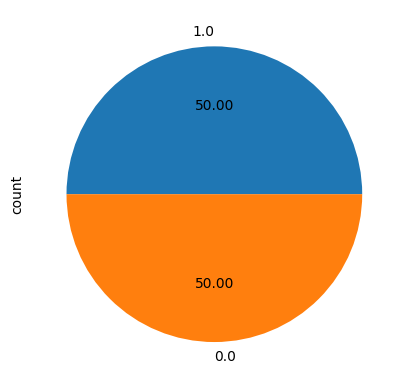

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)


y_train_res.value_counts().plot.pie( autopct='%.2f')

=== RANDOM FOREST ===
Acurácia: 0.6884346959122633
Recall: 0.4190031152647975


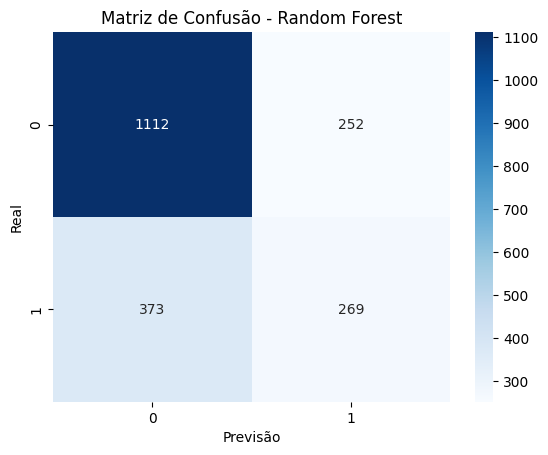

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif


pipeline_rf = Pipeline([
    ('kbest', SelectKBest(k=12)),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("=== RANDOM FOREST ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()


=== MLPClassifier ===
Acurácia: 0.7168494516450648
Recall: 0.4517133956386293


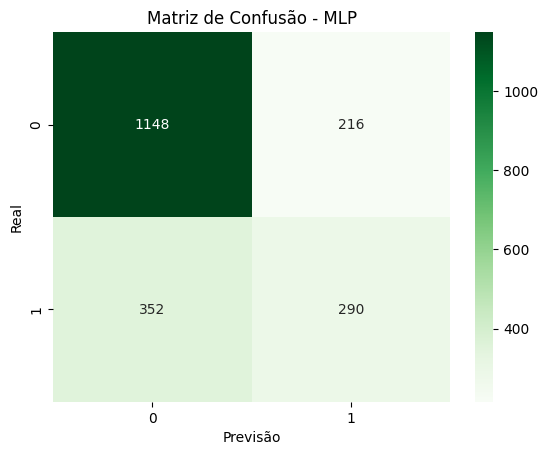

In [ ]:
from sklearn.neural_network import MLPClassifier

pipeline_mlp = Pipeline([
    ('kbest', SelectKBest(k=15)),
    ('model', MLPClassifier(random_state=42, max_iter=300))
])

pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_test)

print("=== MLPClassifier ===")
print("Acurácia:", accuracy_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))

cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - MLP")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()



##Aplicando relação mutua

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define X e y a partir do seu DataFrame
X = df_Numerico_Relevantes.drop(columns=['MH7A'])
y = df_Numerico_Relevantes['MH7A']

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Cria DataFrame com os resultados
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
})

# Ordena por relevância
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)

# Exibe o resultado
print(mi_df_sorted)


                 Feature  Mutual Information
29                   MH6            0.073700
38     Subjective_Income            0.028810
49              MH7B_2_             0.023761
36      Household_Income            0.014328
3                     W4            0.013283
34                Gender            0.013234
48  COUNTRYNEW_Venezuela            0.012867
40    COUNTRYNEW_Bolivia            0.012805
35             Education            0.010983
59            EMP_2010_4            0.010794
30                   W27            0.010180
60            EMP_2010_5            0.010078
27                  MH4B            0.009241
19                  MH2A            0.008500
15                    W8            0.008497
25                  MH3D            0.007641
55             MH7B_2_99            0.007346
7                    W5D            0.006150
61            EMP_2010_6            0.005853
33              age_var3            0.005603
45   COUNTRYNEW_Paraguay            0.005218
44    COUN

In [ ]:
#Filtro baseado nas 8 melhores features

top_features = mi_df_sorted.head(8)['Feature'].tolist()

X_filtrado = X[top_features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtrado, y, test_size=0.2, random_state=42)

###Fazendo o Balanceamento

<Axes: ylabel='count'>

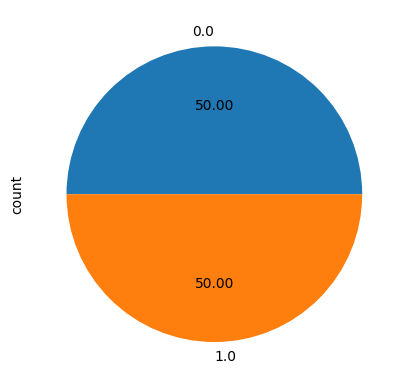

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)


y_train_res.value_counts().plot.pie( autopct='%.2f')

###Random forest

=== RANDOM FOREST ===
Acurácia: 0.6879361914257228
Recall: 0.6474164133738601

Matriz de Confusão:


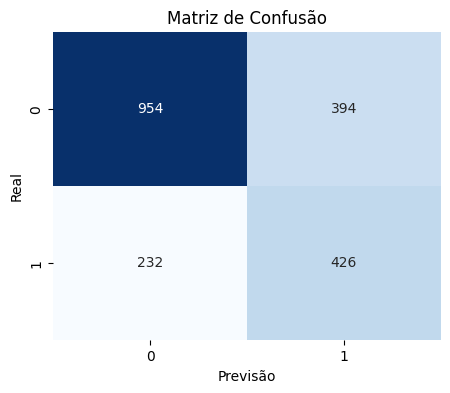

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

# Treinamento
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_res, y_train_res)

# Previsão
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação
print("=== RANDOM FOREST ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("\nMatriz de Confusão:")
# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)  # ou y_pred_mlp, y_pred_gb dependendo do modelo
# Exibe visualmente
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()



###Redes neurais (MLPClassifier)

=== REDE NEURAL (MLP) ===
Acurácia: 0.6969092721834497
Recall: 0.71580547112462

Matriz de Confusão:


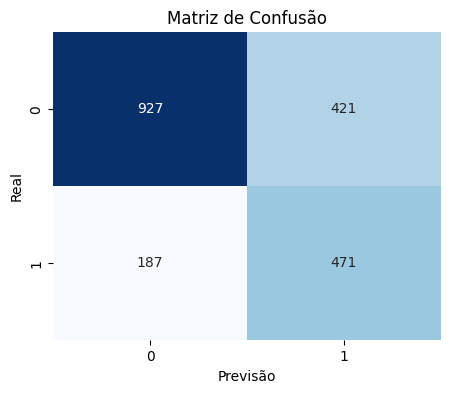

In [ ]:
from sklearn.neural_network import MLPClassifier

# Treinamento
modelo_mlp = MLPClassifier(random_state=42, max_iter=300)
modelo_mlp.fit(X_train_res, y_train_res)

# Previsão
y_pred_mlp = modelo_mlp.predict(X_test)

# Avaliação
print("=== REDE NEURAL (MLP) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
print("\nMatriz de Confusão:")
# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_mlp)  # ou y_pred_mlp, y_pred_gb dependendo do modelo
# Exibe visualmente
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()



###Gradient Boosting

=== GRADIENT BOOSTING ===
Acurácia: 0.6984047856430707
Recall: 0.7264437689969605

Matriz de Confusão:


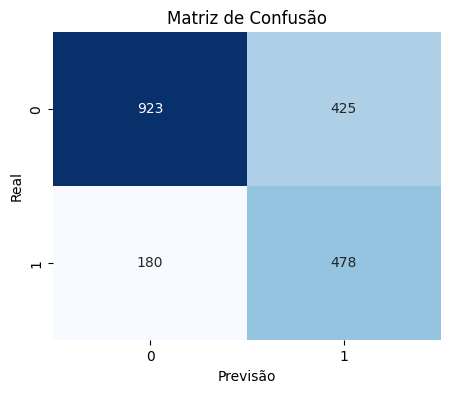

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Treinamento
modelo_gb = GradientBoostingClassifier(random_state=42)
modelo_gb.fit(X_train_res, y_train_res)

# Previsão
y_pred_gb = modelo_gb.predict(X_test)

# Avaliação
print("=== GRADIENT BOOSTING ===")
print("Acurácia:", accuracy_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("\nMatriz de Confusão:")
# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_gb)
# Exibe visualmente
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


##Por filtro da correlação

In [ ]:
#Correlação com a coluna alvo
correlacoes_com_alvo = df_Numerico_Relevantes.corr(numeric_only=True, method='kendall')['MH7A'].sort_values(key=abs, ascending=False)
print(correlacoes_com_alvo)


MH7A                    1.000000
MH6                     0.349585
Subjective_Income       0.196419
MH7B_2_                -0.131514
Household_Income       -0.118687
W3                      0.106724
EMP_2010_4              0.099339
Education              -0.098053
Gender                  0.097819
MH1                     0.095688
W4                     -0.095624
W5A                    -0.094828
EMP_2010_1             -0.089377
COUNTRYNEW_Peru         0.087408
W5E                    -0.081083
W8                     -0.078863
COUNTRYNEW_Paraguay    -0.077835
W9                     -0.075343
W5C                    -0.074170
COUNTRYNEW_Uruguay     -0.070579
EMP_2010_5              0.065863
MH7B_2_5                0.065150
W6                     -0.060330
MH7B_2_2                0.060057
W2                     -0.059203
MH3A                   -0.059129
MH7B_2_99               0.058261
age_var3               -0.056684
W5B                    -0.056407
W7A                    -0.054931
W5D       

###Heatmap

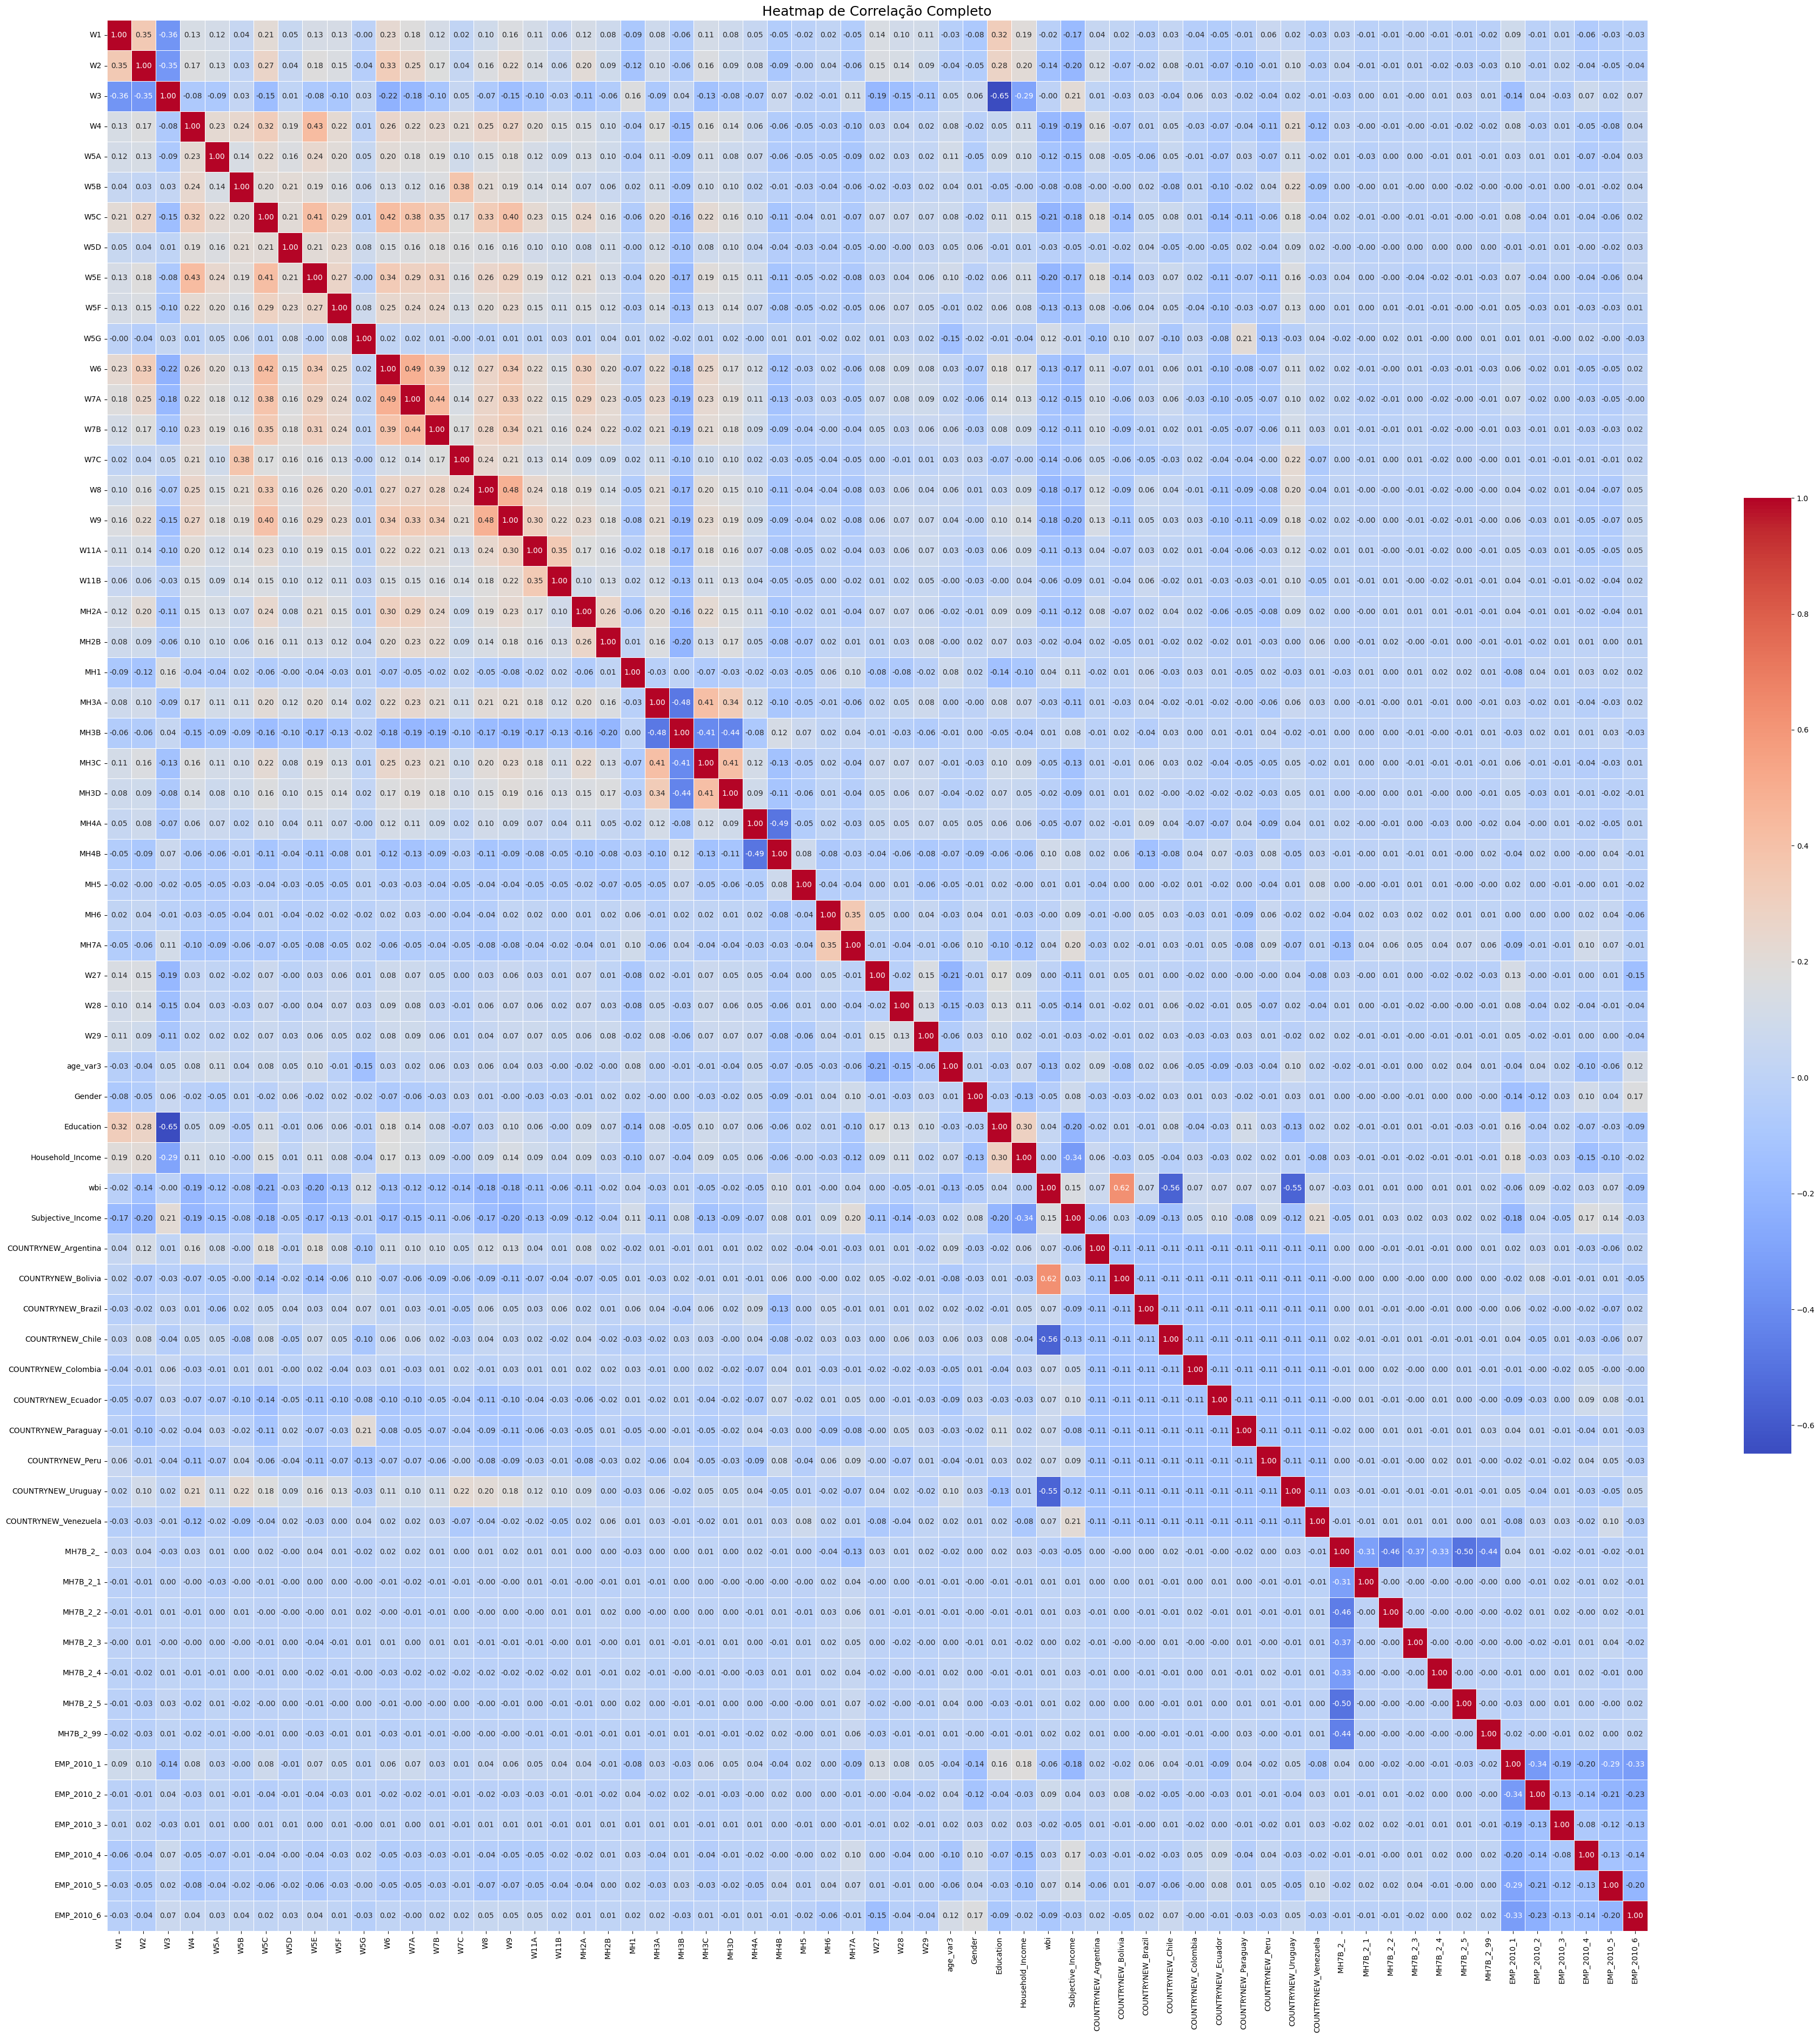

In [ ]:
correlacao = df_Numerico_Relevantes.corr(numeric_only=True, method='kendall')

# Definir o tamanho da figura com base no número de colunas
plt.figure(figsize=(len(correlacao.columns) * 0.6, len(correlacao.columns) * 0.6))

# Gerar o heatmap completo
sns.heatmap(
    correlacao,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=False,
    cbar_kws={"shrink": 0.5}
)

plt.title("Heatmap de Correlação Completo", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#Filtro de limiar
limiar = 0.1
colunas_selecionadas = correlacoes_com_alvo[correlacoes_com_alvo.abs() >= limiar].index.tolist()

print(f"Colunas selecionadas correlação >= {limiar}:")
print(colunas_selecionadas)

df_Numerico_Final = df_Numerico_Relevantes[colunas_selecionadas]

Colunas selecionadas correlação >= 0.1:
['MH7A', 'MH6', 'Subjective_Income', 'MH7B_2_ ', 'Household_Income', 'W3']


In [ ]:
X_cr = df_Numerico_Final.drop('MH7A', axis=1)
y_cr = df_Numerico_Final['MH7A']

In [ ]:
y_cr.value_counts()

,count
MH7A,
0.0,6818
1.0,3210


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cr, y_cr, test_size=0.2, random_state=42)

<Axes: ylabel='count'>

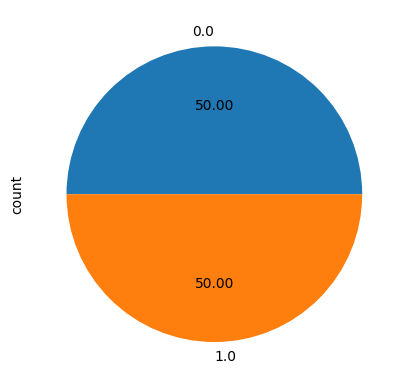

In [ ]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)


y_train_res.value_counts().plot.pie( autopct='%.2f')


###Random Forest

=== RANDOM FOREST ===
Acurácia: 0.6754735792622134
Recall: 0.7142857142857143

Matriz de Confusão:


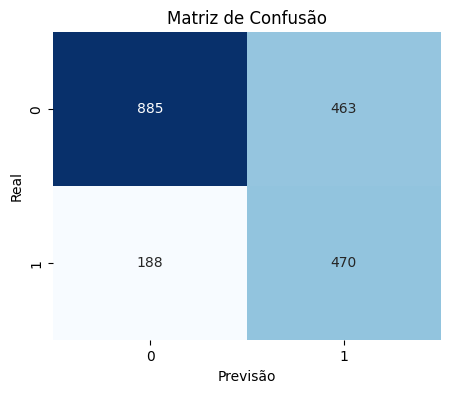

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

# Treinamento
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_res, y_train_res)

# Previsão
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação
print("=== RANDOM FOREST ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

###Rede Neural (MLPClassifier)

=== REDE NEURAL (MLP) ===
Acurácia: 0.650049850448654
Recall: 0.7993920972644377

Matriz de Confusão:


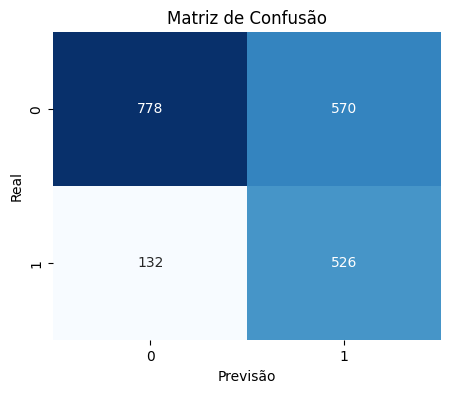

In [ ]:
from sklearn.neural_network import MLPClassifier

modelo_mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
 )
modelo_mlp.fit(X_train_res, y_train_res)

# Previsão
y_pred_mlp = modelo_mlp.predict(X_test)

# Avaliação
print("=== REDE NEURAL (MLP) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
print("\nMatriz de Confusão:")
# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_mlp)
# Exibe visualmente
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


###Gradient Boosting

=== GRADIENT BOOSTING ===
Acurácia: 0.6819541375872383
Recall: 0.7203647416413373

Matriz de Confusão:


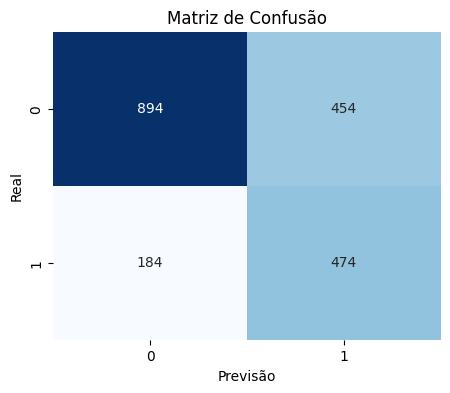

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Treinamento
modelo_gb = GradientBoostingClassifier(random_state=42)
modelo_gb.fit(X_train_res, y_train_res)

# Previsão
y_pred_gb = modelo_gb.predict(X_test)

# Avaliação
print("=== GRADIENT BOOSTING ===")
print("Acurácia:", accuracy_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


##Usando o PCA

In [ ]:
X_crpca = df_Numerico_Final.drop('MH7A', axis=1)
y_crpca = df_Numerico_Final['MH7A']

In [ ]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_crpca)

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



###Random Forest

=== RANDOM FOREST ===
Acurácia: 0.67098703888335
Recall: 0.6853582554517134


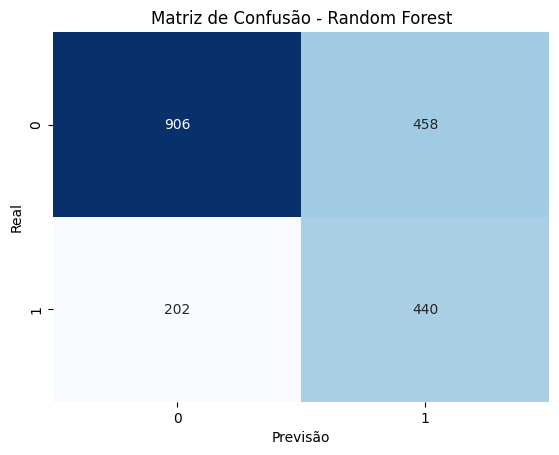

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_res, y_train_res)
y_pred_rf = modelo_rf.predict(X_test)

print("=== RANDOM FOREST ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

###Rede Neural ( MLPclassifier)

=== REDE NEURAL (MLP) ===
Acurácia: 0.6650049850448654
Recall: 0.735202492211838


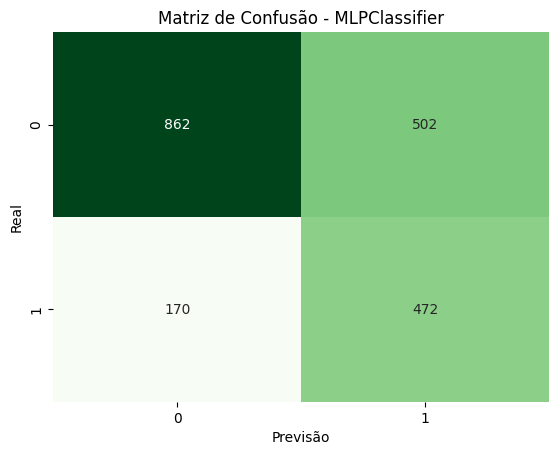

In [ ]:
from sklearn.neural_network import MLPClassifier

modelo_mlp = MLPClassifier(random_state=42, max_iter=300)
modelo_mlp.fit(X_train_res, y_train_res)
y_pred_mlp = modelo_mlp.predict(X_test)

print("=== REDE NEURAL (MLP) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Matriz de Confusão - MLPClassifier")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

###Gradient Boosting

=== GRADIENT BOOSTING ===
Acurácia: 0.6804586241276172
Recall: 0.6744548286604362


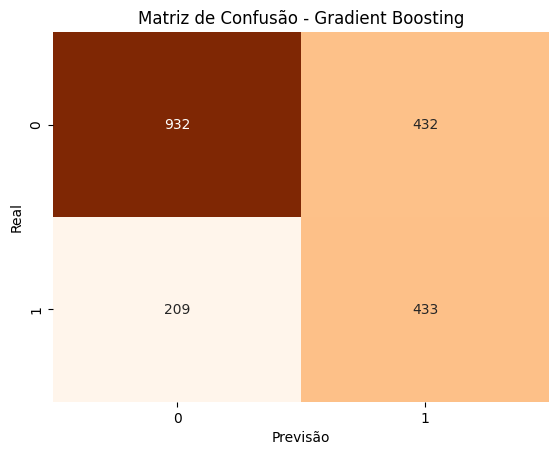

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

modelo_gb = GradientBoostingClassifier(random_state=42)
modelo_gb.fit(X_train_res, y_train_res)
y_pred_gb = modelo_gb.predict(X_test)

print("=== GRADIENT BOOSTING ===")
print("Acurácia:", accuracy_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Matriz de Confusão - Gradient Boosting")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()
